In [7]:
import sys
import os
import numpy as np
import math 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from gate import Gate, GateFC, GateSingle, Gate2, TwoLevelUnitary
from utils import PAULI_X, is_unitary, is_special_unitary, is_power_of_two, IDENTITY_2x2, permute_matrix
# find TODOs 
'''test_utils.py 
'''

# How code is transferred from the quantum_decomposition repo
'''
gate.py, gate2.py, two_level Unitary.py => gate.py
utils.py 
'''
'''quantum_decomp_main.py
two_level_decompose_gray()
matrix_to_gates()
matrix_to_qiskit_circuit() 
'''

'quantum_decomp_main.py\ntwo_level_decompose_gray()\nmatrix_to_gates()\nmatrix_to_qiskit_circuit() \n'

In [8]:
def unitary2x2_to_gates(A):
    """Decomposes 2x2 unitary to gates Ry, Rz, R1.
    R1(x) = diag(1, exp(i*x)).
    """
    assert is_unitary(A)
    phi = np.angle(np.linalg.det(A))
    if np.abs(phi) < 1e-9:
        return su_to_gates(A)
    elif np.allclose(A, PAULI_X):
        return [Gate2('X')]
    else:
        A = np.diag([1.0, np.exp(-1j * phi)]) @ A
        return su_to_gates(A) + [Gate2('R1', phi)]
    
def unitary2x2_to_gates_sk(A, basis=None, depth=3):
    """ Decomposes 2x2 unitary to gates into a sequence of gates from basis. 
    :param A: matrix to decompose.
    :param basis: a list of names of gates representing instruction set provided by hardware.  
    :return: List of Gate2 gates from the basis set that approximates A. 
    """
    # TODO 
    # find qiskit sk basis gate available options and add them to Gate2 and gate_to_qiskit
    # fill in my own version of implmentation for sk using Gate2 objects
    # fill in my own version of implmentation for universal decomposition 
    
    from qiskit.circuit import QuantumCircuit
    from qiskit.transpiler.passes.synthesis import SolovayKitaev
    from qiskit.quantum_info import Operator
    from qiskit.synthesis import generate_basic_approximations
    from qiskit.transpiler.passes import SolovayKitaev
#     from qiskit import QuantumCircuit
    from qiskit.extensions import UnitaryGate
    

    assert is_unitary(A)
    # Henry: Modified the routine  to use Solovay-Kitaev algorithm for single qubite gates
    if basis!=None:
        # TODO: What are the available gate options 
        approx = generate_basic_approximations(basis, depth=depth)
        skd = SolovayKitaev(recursion_degree=depth, basic_approximations=approx)
    else: 
        skd = SolovayKitaev(recursion_degree=depth)
    gate = UnitaryGate(A)
    circuit = QuantumCircuit(1)
    circuit.append(gate, [0])
    discretized = skd(circuit)
    
    compiled_seq = []
    for gate in discretized.data:  
        # todo: Need a routine to convert qiskit gates to Gate2 Objects defined in gate.py
        # For now, having H and T gates will suffice 
        # print(gate[0].name)
        gate2 = None
        if gate[0].name == 'h': 
            gate2 = Gate2('H')
            compiled_seq.append(gate2)
        elif gate[0].name == 't':
            gate2 = Gate2('T')
            compiled_seq.append(gate2)
        # print('\ngate name:', gate[0].name)
        # print('qubit(s) acted on:', gate[1])
        # print('other paramters (such as angles):', gate[0].params)
    return compiled_seq
    
    
def two_level_decompose(A):
    """Returns list of two-level unitary matrices, which multiply to A.
    Matrices are listed in application order, i.e. if answer is
    [u_1, u_2, u_3], it means A = u_3 u_2 u_1.
    :param A: matrix to decompose.
    :return: The decomposition - list of two-level unitary matrices.
    """

    def make_eliminating_matrix(a, b):
        """Returns unitary matrix U, s.t. [a, b] U = [c, 0].

        Makes second element equal to zero.
        Guarantees np.angle(c)=0.
        """
        assert (np.abs(a) > 1e-9 and np.abs(b) > 1e-9)
        theta = np.arctan(np.abs(b / a))
        lmbda = -np.angle(a)
        mu = np.pi + np.angle(b) - np.angle(a) - lmbda
        result = np.array([[np.cos(theta) * np.exp(1j * lmbda),
                            np.sin(theta) * np.exp(1j * mu)],
                           [-np.sin(theta) * np.exp(-1j * mu),
                            np.cos(theta) * np.exp(-1j * lmbda)]])
        assert is_special_unitary(result)
        assert np.allclose(np.angle(result[0, 0] * a + result[1, 0] * b), 0)
        assert (np.abs(result[0, 1] * a + result[1, 1] * b) < 1e-9)
        return result

    assert is_unitary(A)
    n = A.shape[0]
    result = []
    # Make a copy, because we are going to mutate it.
    cur_A = np.array(A)

    for i in range(n - 2):
        for j in range(n - 1, i, -1):
            a = cur_A[i, j - 1]
            b = cur_A[i, j]
            if abs(cur_A[i, j]) < 1e-9:
                # Element is already zero, nothing to do.
                u_2x2 = IDENTITY_2x2
                # But if it's last in row, ensure diagonal element will be 1.
                if j == i + 1:
                    u_2x2 = np.array([[1 / a, 0], [0, a]])
            elif abs(cur_A[i, j - 1]) < 1e-9:
                # Just swap columns.
                u_2x2 = PAULI_X
                # But if it's last in row, ensure diagonal element will be 1.
                if j == i + 1:
                    u_2x2 = np.array([[0, b], [1 / b, 0]])
            else:
                u_2x2 = make_eliminating_matrix(a, b)
            u_2x2 = TwoLevelUnitary(u_2x2, n, j - 1, j)
            u_2x2.multiply_right(cur_A)
            if not u_2x2.is_identity():
                result.append(u_2x2.inv())

        # After we are done with row, diagonal element is 1.
        assert np.allclose(cur_A[i, i], 1.0)

    last_matrix = TwoLevelUnitary(cur_A[n - 2:n, n - 2:n], n, n - 2, n - 1)
    if not last_matrix.is_identity():
        result.append(last_matrix)

    return result

def two_level_decompose_gray(A):
    """Returns list of two-level matrices, which multiply to A.

    :param A: matrix to decompose.
    :return: The decomposition - list of two-level unitary matrices. Guarantees
      that each matrix acts on single bit.
    """
    N = A.shape[0]
    assert is_power_of_two(N)
    assert A.shape == (N, N), "Matrix must be square."
    assert is_unitary(A)

    perm = [x ^ (x // 2) for x in range(N)]  # Gray code.
    result = two_level_decompose(permute_matrix(A, perm))
    for matrix in result:
        matrix.apply_permutation(perm)
    return result

def add_flips(flip_mask, gates):
    """Adds X gates for all qubits specified by qubit_mask."""
    qubit_id = 0
    while (flip_mask > 0):
        if (flip_mask % 2) == 1:
            gates.append( GateSingle(Gate2('X'), qubit_id) )
        flip_mask //= 2
        qubit_id += 1

def matrix_to_gates(A, **kwargs):
    """Given unitary matrix A, returns sequence of gates which implements
    action of this matrix on register of qubits.

    If optimized=True, applies optimized algorithm yielding less gates. Will
    affect output only when A is 4x4 matrix.

    :param A: 2^N x 2^N unitary matrix.
    :return: sequence of `Gate`s.
    """
    if 'optimize' in kwargs and kwargs['optimize'] and A.shape[0] == 4:
        return decompose_4x4_optimal(A)

    matrices = two_level_decompose_gray(A)
    gates = []
    prev_flip_mask = 0

    for matrix in matrices:
        matrix.order_indices()  # Ensures that index2 > index1.
        qubit_id_mask = matrix.index1 ^ matrix.index2
        
        assert is_power_of_two(qubit_id_mask)
        qubit_id = int(math.log2(qubit_id_mask))
        flip_mask = (matrix.matrix_size - 1) - matrix.index2
        add_flips(flip_mask ^ prev_flip_mask, gates)

#         for gate2 in unitary2x2_to_gates(matrix.matrix_2x2):
#             gates.append(GateFC(gate2, qubit_id))
        for gate2 in unitary2x2_to_gates_sk(matrix.matrix_2x2):
            gates.append(GateFC(gate2, qubit_id))
        prev_flip_mask = flip_mask
    add_flips(prev_flip_mask, gates)

    return gates

def matrix_to_qiskit_circuit(A, **kwargs):
    """Converts unitary matrix to Qiskit circuit.
    :param A: 2^N x 2^N unitary matrix.
    :return: `qiskit.QuantumCircuit` implementing this matrix.
    """
    from qiskit import QuantumCircuit
    from qiskit.circuit.library import XGate, RYGate, RZGate, U1Gate, HGate, TGate

    def gate_to_qiskit(gate2):
        if gate2.name == 'X':
            return XGate()
        if gate2.name == 'T':
            return TGate()
        if gate2.name == 'H':
            return HGate()
        elif gate2.name == 'Ry':
            return RYGate(-gate2.arg)
        elif gate2.name == 'Rz':
            return RZGate(-gate2.arg)
        elif gate2.name == 'R1':
            return U1Gate(gate2.arg)
        else:
            raise RuntimeError("Can't implement: %s" % gate2)

    gates = matrix_to_gates(A, **kwargs)
    qubits_count = int(np.log2(A.shape[0]))
    circuit = QuantumCircuit(qubits_count)
    qubits = circuit.qubits

    for gate in gates:
        if isinstance(gate, GateFC):
            controls = [qubits[i]
                        for i in range(qubits_count) if i != gate.qubit_id]
            target = qubits[gate.qubit_id]
            arg_gates = controls + [target]
            cgate = gate_to_qiskit(gate.gate2)
            if len(controls):
                cgate = cgate.control(num_ctrl_qubits=len(controls))
            circuit.append(cgate, arg_gates)
        elif isinstance(gate, GateSingle):
            circuit.append(gate_to_qiskit(gate.gate2), [qubits[gate.qubit_id]])
        else:
            raise RuntimeError('Unknown gate type.')
    return circuit

### 

/home/henlibo/GitHub/quantum-compilation/gate.py:162: ComplexWarning: Casting complex values to real discards the imaginary part
  A[:, idx] = A[:, idx] @ self.matrix_2x2


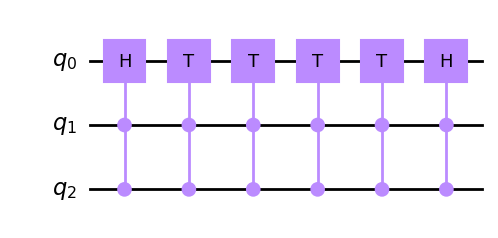

In [13]:
from scipy.stats import unitary_group
# SWAP = np.array([[1, 0, 0, 0],
#                  [0, 0, 1, 0],
#                  [0, 1, 0, 0],
#                  [0, 0, 0, 1]])

CCX = np.array([ [1, 0, 0, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0, 0, 0],
                 [0, 0, 0, 0, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 0, 1, 0]])
n = 3
# targetGate = unitary_group.rvs(2**n)
# print(targetGate)
circ_out = matrix_to_qiskit_circuit(CCX)
circ_out.draw(output='mpl')

### Work in Progress


In [ ]:
def su_to_gates(A):
    """Decomposes 2x2 special unitary to gates Ry, Rz.

    R_k(x) = exp(0.5*i*x*sigma_k).
    """
    assert is_special_unitary(A)
    u00 = A[0, 0]
    u01 = A[0, 1]
    theta = np.arccos(np.abs(u00))
    lmbda = np.angle(u00)
    mu = np.angle(u01)

    result = []
    if np.abs(lmbda - mu) > 1e-9:
        result.append(Gate2('Rz', lmbda - mu))
    if np.abs(theta) > 1e-9:
        result.append(Gate2('Ry', 2 * theta))
    if np.abs(lmbda + mu) > 1e-9:
        result.append(Gate2('Rz', lmbda + mu))
    return result

In [ ]:
def reduce(a, b): 
    '''
    Reduce elements (i, i+1) by U
    '''
    if b == 0:
        return np.identity(2, dtype=complex)
    if a == 0: 
        return np.array([[0,1], [1,0]],  dtype=complex)
    t = np.arctan2(np.abs(b), np.abs(a)) # theta
    l = -np.angle(a)          # lambda
    m = np.pi + np.angle(b)   # mu  
    U = np.array( [[ np.cos(t)*np.exp(l*1j), np.sin(t)*np.exp(m*1j)],
                   [-np.sin(t)*np.exp(-m*1j), np.cos(t)*np.exp(-l*1j)]])
    return U 

def gray_code(n):
    return [i^i//2 for i in range(2**n)]

def two_level_decompose(A):
    '''
    Decomposes A into a list of 2-level matrices such that the product 
    of the list will be A. 
    '''
    assert A.shape[0] == A.shape[1]
    d = A.shape[0]
    decomp = []
    for s in range(d-2):
        for i in range(d,s+1,-1):
            b = A[s][i-1]
            a = A[s][i-2]
            I = np.identity(d, dtype=np.cdouble)
            U = reduce(a, b)
            for j in range(2):
                for k in range(2): 
                    I[i-2+j][i-2+k] = U[j][k]    
            decomp.append(I.conj().T)
            A = A @ I
    decomp.append(A)
    return decomp


def two_level_decompose_gray(A): 
    '''
    Decomposes A into a sequence of 2-level matrices such that acts on
    basis states that diff. in only one bit.
    '''
    assert A.shape[0] == A.shape[1]
    d = A.shape[0]
    P = np.zeros((d, d))
    gcode = gray_code(int(np.log2(d)))
    
    for i in range(d): 
        for j in range(d): 
            if gcode[j] == i:
                P[i][j] = 1
    D = two_level_decompose(P @ A @ P.T)
    
    for i in range(len(D)):
        D[i] = P.T @ D[i] @ P
    return D 

        
def YZ_decompose(U): 
    '''
    Single qubit gate U can be implemented using four gates. 
    U = R_1(phi) R_z(l+u) R_y(2t) R_z(l-u)
    
    R_1(a) = [[1,0],[0,e^ia]]
    R_y = exp(iaY/2)
    R_z = exp(iaZ/2)
    '''
    assert U.shape == (2,2)
    phi = np.angle( np.linalg.det(U) ) 
    t = np.arccos(np.abs(U[0][0])) 
    l = np.angle(U[0][0])
    u = np.angle(U[0][1])

In [ ]:
n = 3
targetGate = unitary_group.rvs(2**n)
np.set_printoptions(suppress=True, precision=3)

# Test to recover a target gate to be decomposed
D = two_level_decompose_gray(targetGate)
S = np.identity(targetGate.shape[0])
for m in D:
    S = m @ S
print(S-targetGate)

In [ ]:
two_level_decompose(targetGate)
gray_code(2)

In [ ]:
# Test to recover a target gate to be decomposed 
n = 3
from scipy.stats import unitary_group
targetGate = unitary_group.rvs(2**n)
np.set_printoptions(suppress=True, precision=3)
two_level_decompose_gray(targetGate)